In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.44:43187")
client

Client Scheduler: tcp://10.32.16.44:43187 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 20 Cores: 40 Memory: 230.00 GB


# Comparing SOSE and WOA datasets
for model validation

# SOSE

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline

In [3]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-sose'), consolidated=True)

In [4]:
coords = ds.coords.to_dataset().reset_coords()
dsr = ds.reset_coords(drop=True)

In [5]:
lower_lat = 0
upper_lat = 78
left_lon = 1788
right_lon = 2159

In [6]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [7]:
salt = dsr.SALT.isel(**lat_range, **lon_range)
temp = dsr.THETA.isel(**lat_range, **lon_range)

# xhistogram T/S Diagram from SOSE

In [8]:
from xhistogram.xarray import histogram
import numpy as np
from matplotlib.colors import LogNorm

In [9]:
salt_bins = np.linspace(31, 35, 100)
theta_bins = np.linspace(-2.2, 8, 100)
delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

vol = (coords.hFacC * coords.rA * coords.drF).isel(**lat_range, **lon_range)

In [10]:
ts_hist = histogram(temp, salt, bins=[theta_bins, salt_bins],
                    weights=vol, dim=['XC', 'YC', 'Z']).rename({'THETA_bin':'theta_bin',
                                                                        'SALT_bin':'salt_bin'}) / (delta_salt * delta_theta)

In [11]:
#taking hist mean over `time` takes average (notice the scales are diff in either plots)
ts_hist_mean = ts_hist.mean(dim='time')

Text(0, 0.5, 'Potential Temperature [˚C]')

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


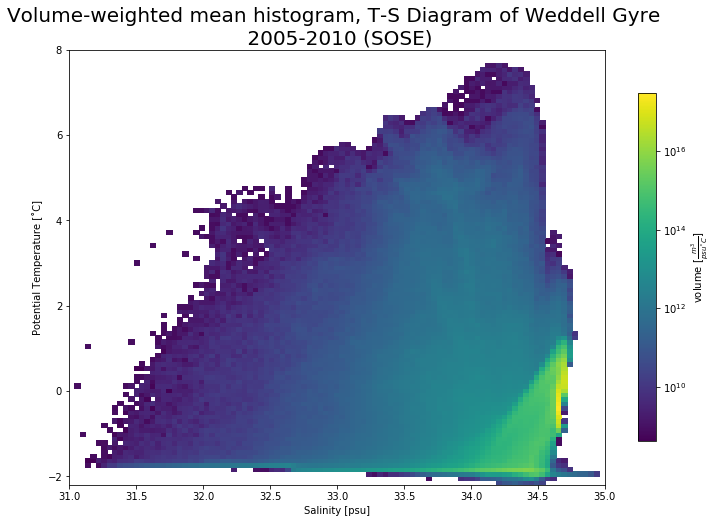

In [12]:
ts_hist_mean.where(ts_hist_mean>0).plot(norm=LogNorm(), figsize=(12,8), cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 2005-2010 (SOSE)', fontsize=20)
plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')

# WOA 1981-2010

In [13]:
ds_salt = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/salt')
ds_temp = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/temp')
ds_8110 = xr.merge([ds_salt, ds_temp])

In [14]:
lower_lat_woa = -79.88
upper_lat_woa = -59.88
left_lon_woa = -74.88
right_lon_woa = 30.12

In [15]:
#set the boundaries
lat_range_woa = dict(lat=slice(lower_lat_woa, upper_lat_woa))
lon_range_woa = dict(lon=slice(left_lon_woa, right_lon_woa))

In [16]:
temp_8110 = ds_8110.tan.sel(**lat_range_woa, **lon_range_woa).rename('theta')
salt_8110 = ds_8110.san.sel(**lat_range_woa, **lon_range_woa).rename('salt')

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


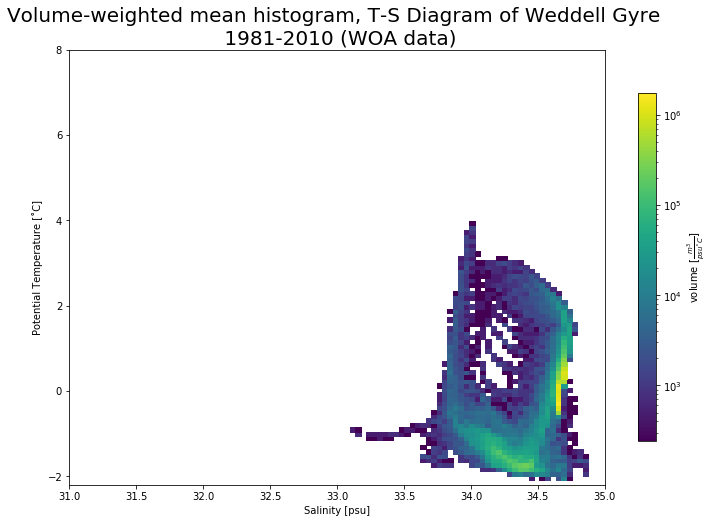

In [17]:
ts_hist_8110 = histogram(temp_8110, salt_8110, bins=[theta_bins, salt_bins]) / (delta_salt * delta_theta)
ts_hist_8110.where(ts_hist_8110>0).plot(norm=LogNorm(), figsize=(12,8), 
                              cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 1981-2010 (WOA data)', fontsize=20);

## Difference

In [18]:
ts_hist_mean

<xarray.DataArray 'histogram_THETA_SALT' (theta_bin: 99, salt_bin: 99)>
dask.array<mean_agg-aggregate, shape=(99, 99), dtype=float64, chunksize=(99, 99), chunktype=numpy.ndarray>
Coordinates:
  * theta_bin  (theta_bin) float64 -2.148 -2.045 -1.942 ... 7.742 7.845 7.948
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [19]:
ts_hist_8110

<xarray.DataArray 'histogram_theta_salt' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.148 -2.045 -1.942 ... 7.742 7.845 7.948
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [20]:
ts_hist_sose_8110 = ts_hist_mean - ts_hist_8110
ts_hist_sose_8110.load()

<xarray.DataArray (theta_bin: 99, salt_bin: 99)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.05055034e+11, 1.43022705e+10, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.148 -2.045 -1.942 ... 7.742 7.845 7.948
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


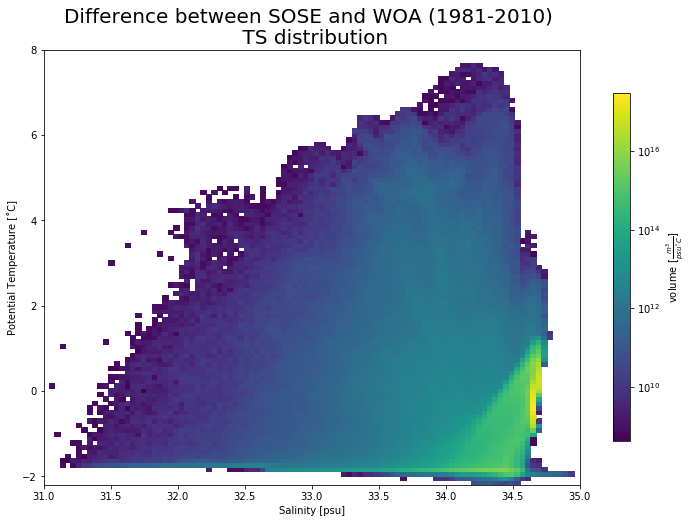

In [21]:
ts_hist_sose_8110.where(ts_hist_sose_8110>0).plot(norm=LogNorm(), figsize=(12,8), 
                              cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('Difference between SOSE and WOA (1981-2010) \n TS distribution', fontsize=20);

# WOA 2005-2017

In [22]:
ds_salt_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/salt')
ds_temp_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/temp')
ds_0517 = xr.merge([ds_salt_0517, ds_temp_0517])

In [23]:
temp_0517 = ds_0517.tan.sel(**lat_range_woa, **lon_range_woa).rename('theta')
salt_0517 = ds_0517.san.sel(**lat_range_woa, **lon_range_woa).rename('salt')

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


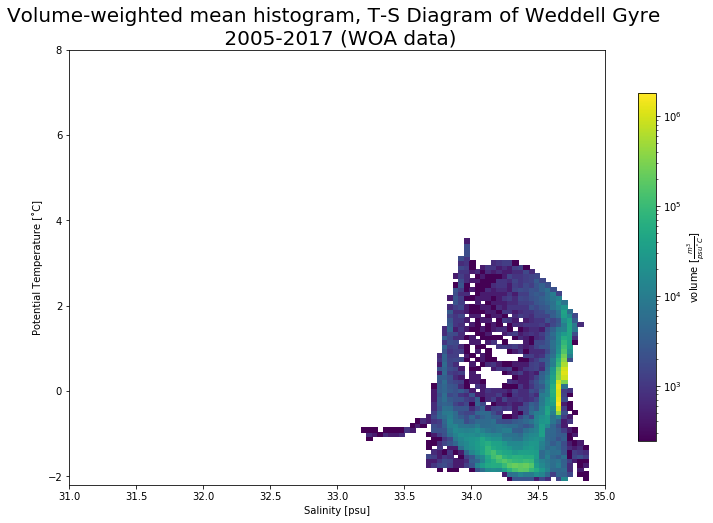

In [24]:
ts_hist_0517 = histogram(temp_0517, salt_0517, bins=[theta_bins, salt_bins]) / (delta_salt * delta_theta)
ts_hist_0517.where(ts_hist_0517>0).plot(norm=LogNorm(), figsize=(12,8), 
                                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 2005-2017 (WOA data)', fontsize=20);

## Difference

In [25]:
ts_hist_sose_0517 = ts_hist_mean - ts_hist_0517
ts_hist_sose_0517.load()

<xarray.DataArray (theta_bin: 99, salt_bin: 99)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.05055034e+11, 1.43022705e+10, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.148 -2.045 -1.942 ... 7.742 7.845 7.948
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


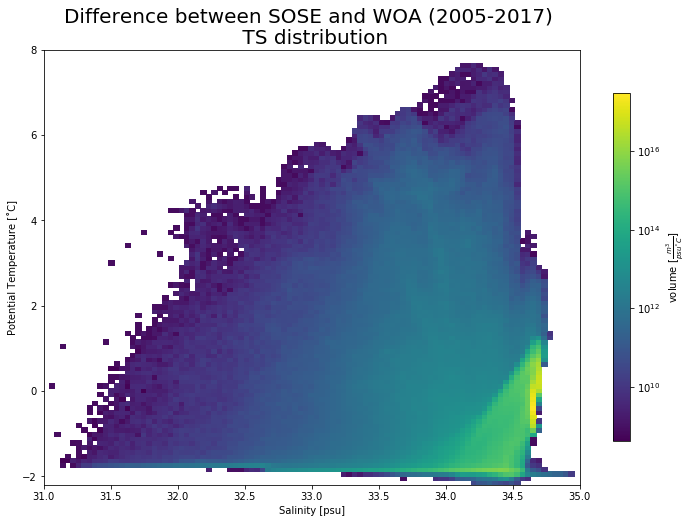

In [26]:
ts_hist_sose_0517.where(ts_hist_sose_0517>0).plot(norm=LogNorm(), figsize=(12,8), 
                              cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('Difference between SOSE and WOA (2005-2017) \n TS distribution', fontsize=20);